# Практическое задание к уроку 2

In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score,roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as st
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline


In [2]:
train=pd.read_csv('assignment_train.csv')
test=pd.read_csv('assignment_test.csv')

In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3062002,0,1643519,49.0,W,14935,543.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3062003,0,1643519,100.0,R,8394,490.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3062004,0,1643529,97.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Задание на повторение:

#### 1. Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи

(array([ 8222., 10116., 11623.,  9390.,  6429.,  6283.,  5919.,  5012.,
         5748.,  6258.]),
 array([1643492. , 1788483.6, 1933475.2, 2078466.8, 2223458.4, 2368450. ,
        2513441.6, 2658433.2, 2803424.8, 2948416.4, 3093408. ]),
 <a list of 10 Patch objects>)

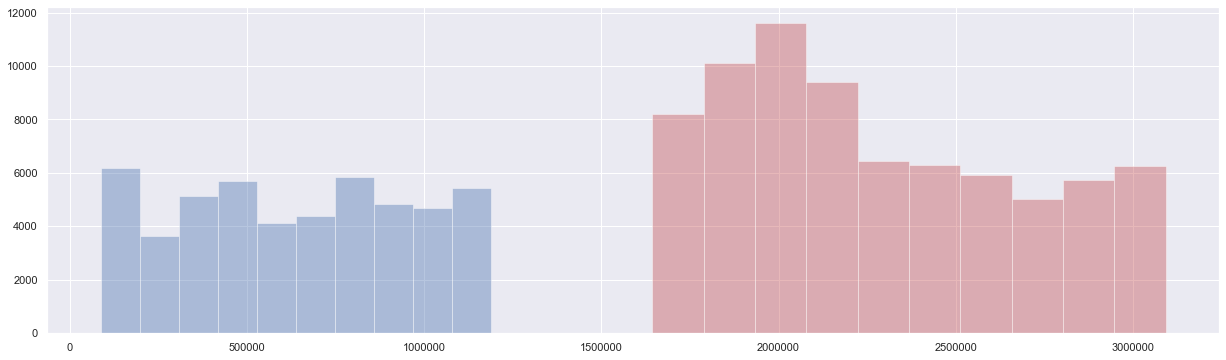

In [81]:
fig = plt.figure(figsize=(21, 6))
plt.subplot()
plt.hist(train["TransactionDT"], alpha=0.4,color='b')
plt.subplot()
plt.hist(test["TransactionDT"], alpha=0.4,color='r')

Для временого ряда данные разбиты корректно тестовая выборка расположена в следующем диапазоне времени по отношению к тренировочной, существует отсутствие данных в диапазоне 15000. применение крос валидации для временных рядов

#### 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

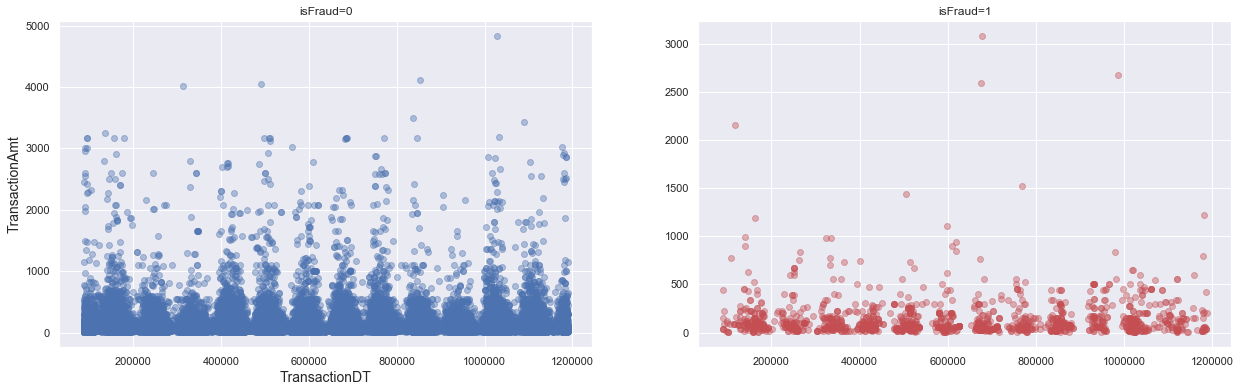

In [80]:
fig = plt.figure(figsize=(21, 6))
plt.subplot(121)
train_copy=train.copy()
train_False=train_copy[train_copy['isFraud']==0]
train_True=train_copy[train_copy['isFraud']==1]
plt.scatter(x=train_False["TransactionDT"],y=train_False['TransactionAmt'], alpha=0.4,color='b')
plt.title('isFraud=0')
plt.ylabel("TransactionAmt", size=14)
plt.xlabel('TransactionDT', size=14)
plt.subplot(122)
plt.title('isFraud=1')
plt.scatter(x=train_True["TransactionDT"],y=train_True['TransactionAmt'], alpha=0.4,color='r')

Text(0.5, 0, 'TransactionDT')

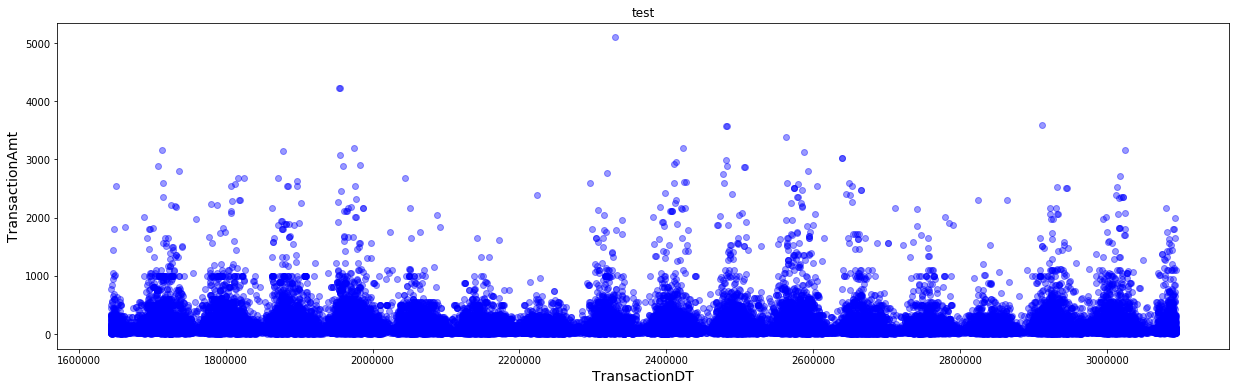

In [44]:
fig = plt.figure(figsize=(21, 6))
plt.scatter(x=test["TransactionDT"],y=test['TransactionAmt'], alpha=0.4,color='b')
plt.title('test')
plt.ylabel("TransactionAmt", size=14)
plt.xlabel('TransactionDT', size=14)

Для признака isFraud заметно соредоточенность транзакций в ниженем диапазоне сумм что характерно для банковских операций. в целом зависимости test train визуально совпадают. по графикам можно гоаорить о какойто сезонности платежей связаных с временем.

#### 3.построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы

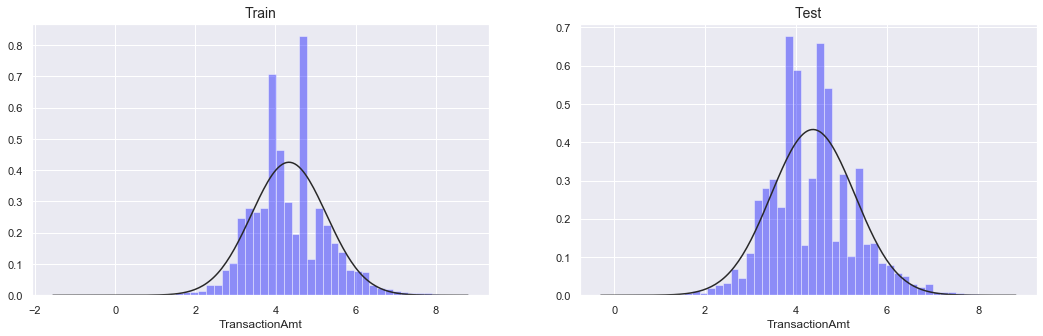

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
#plt.subplot(121)

axes[0].set_title("Train", fontsize=14)
axes[1].set_title("Test", fontsize=14)
#plt.hist(np.log(), alpha=0.4,color='b')
sns.distplot(np.log(train["TransactionAmt"]), kde=False, color="blue", fit=st.norm, ax=axes[0])
#plt.subplot(122)
sns.distplot(np.log(test["TransactionAmt"]), kde=False, color="blue", fit=st.norm, ax=axes[1])

распределение стремится к нормальному. 

#### 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы

In [65]:
columns=['ProductCD','card4','card6']
categorical_features = train[columns]

print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)

Categorical Feature Count 3


,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit


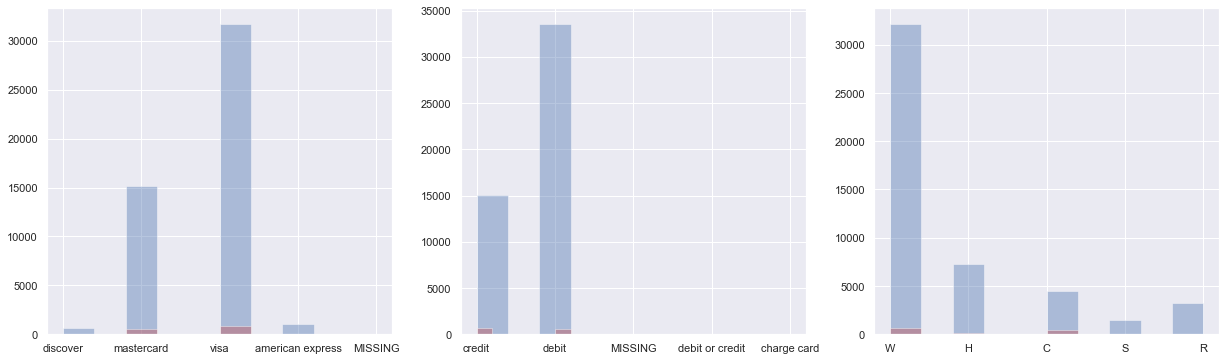

In [78]:
train_copy=train.copy()
train_False=train_copy[train_copy['isFraud']==0]
train_True=train_copy[train_copy['isFraud']==1]
fig = plt.figure(figsize=(21, 6))
for number, future in enumerate (columns):
    plt.subplot(f'13{number}')
    plt.hist(x=train_False[future], alpha=0.4,color='b')
    plt.hist(x=train_True[future], alpha=0.4,color='r')

по категориальным признакам в разрезе целевой переменной наблюдаем явления что по кат. признаком основное распределение целевой переменной с признаком isFraud=1 идет по 2 категориям.

### Основное задание:

#### 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [9]:
import catboost

In [13]:
data_train=train.copy()
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [14]:
categorical_features = data_train.select_dtypes(include=['object','category'])

#categorical_features.drop(['P_emaildomain',	'R_emaildomain'],axis=1,inplace=True)
categorical_features

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,R,visa,credit,hotmail.com,hotmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49997,W,visa,credit,hotmail.com,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN
49998,C,mastercard,debit,hotmail.com,hotmail.com,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN
49999,R,discover,credit,gmail.com,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
for features in categorical_features:
    print(features,train[features].value_counts())
    print(10*'-')

ProductCD W    32799
H     7450
C     4934
R     3354
S     1464
Name: ProductCD, dtype: int64
----------
card4 visa                32562
mastercard          15696
american express     1083
discover              654
Name: card4, dtype: int64
----------
card6 debit              34206
credit             15786
debit or credit        3
charge card            3
Name: card6, dtype: int64
----------
P_emaildomain gmail.com           17910
yahoo.com            8360
hotmail.com          3728
anonymous.com        3466
aol.com              2443
comcast.net           849
icloud.com            468
msn.com               387
outlook.com           360
att.net               326
sbcglobal.net         307
verizon.net           288
live.com              247
ymail.com             184
bellsouth.net         182
cox.net               157
charter.net           141
me.com                134
yahoo.com.mx          126
optonline.net         104
live.com.mx            71
rocketmail.com         59
earthlink.net     

In [16]:
for features in categorical_features.columns:
    data_train[features].fillna('A',inplace=True)
    
for features in ['V330',	'V331',	'V332',	'V333','V334',	'V335',	'V336',	'V337',	'V338',	'V339']:
    data_train[features].fillna(10,inplace=True)    

In [17]:
for features in categorical_features.columns:
    test[features].fillna('A',inplace=True)
    
for features in ['V330',	'V331',	'V332',	'V333','V334',	'V335',	'V336',	'V337',	'V338',	'V339']:
    test[features].fillna(10,inplace=True)    

In [18]:
data_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
x_train, x_test,y_train, y_test= train_test_split(
    data_train.drop(["isFraud"], axis=1), data_train["isFraud"], train_size=0.7, shuffle=True, random_state=21,
)


In [30]:
model = catboost.CatBoostClassifier(random_state=21,cat_features=categorical_features,silent=True,l2_leaf_reg=2)
model.fit(x_train, y_train,use_best_model=True,eval_set=(x_test,y_test))

In [31]:
train_ROC_AUC = roc_auc_score(y_train, model.predict(x_train))
valid_ROC_AUC = roc_auc_score(y_test, model.predict(x_test))
test_ROC_AUC = roc_auc_score(test['isFraud'], model.predict(test.drop('isFraud',axis=1)))

print(f"Train-score: {round(train_ROC_AUC, 3)}, Valid-score: {round(valid_ROC_AUC, 3)}, Test-score: {round(test_ROC_AUC, 3)}")

Train-score: 0.781, Valid-score: 0.692, Test-score: 0.631


Модель явно переобучена, расхождение качества на train и test >0.1.  

#### 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [21]:
x_train, x_test,y_train, y_test= train_test_split(
    data_train.drop(["isFraud"], axis=1), data_train["isFraud"], train_size=0.7, shuffle=True, random_state=21,
)

In [33]:
x_train, x_valid,y_train, y_valid= train_test_split(
    x_train, y_train, train_size=0.8, shuffle=True, random_state=21,
)

In [36]:
model = catboost.CatBoostClassifier(random_state=21,cat_features=categorical_features,silent=True,l2_leaf_reg=2)
model.fit(x_train, y_train,use_best_model=True,eval_set=(x_valid,y_valid))

In [38]:
train_ROC_AUC = roc_auc_score(y_train, model.predict(x_train))
train_valid_ROC_AUC = roc_auc_score(y_valid, model.predict(x_valid))
valid_ROC_AUC = roc_auc_score(y_test, model.predict(x_test))
test_ROC_AUC = roc_auc_score(test['isFraud'], model.predict(test.drop('isFraud',axis=1)))

print(f"Train-score: {round(train_ROC_AUC, 3)},Train_Valid-score: {round(train_valid_ROC_AUC, 3)} Valid-score: {round(valid_ROC_AUC, 3)}, Test-score: {round(test_ROC_AUC, 3)}")

Train-score: 0.748,Train_Valid-score: 0.706 Valid-score: 0.68, Test-score: 0.636


Немного улучшилось разрыв сократился хотя не сильно. хотя на тестовой выборки показатели не очень хороши.

#### 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [39]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [40]:
np.random.seed(27)
scores = create_bootstrap_metrics(test["isFraud"], model.predict(test.drop(["isFraud"], axis=1)), roc_auc_score)

calculate_confidence_interval(scores)

(0.6253628039431202, 0.6455575924173204)

Text(0.5, 0, 'sampel number')

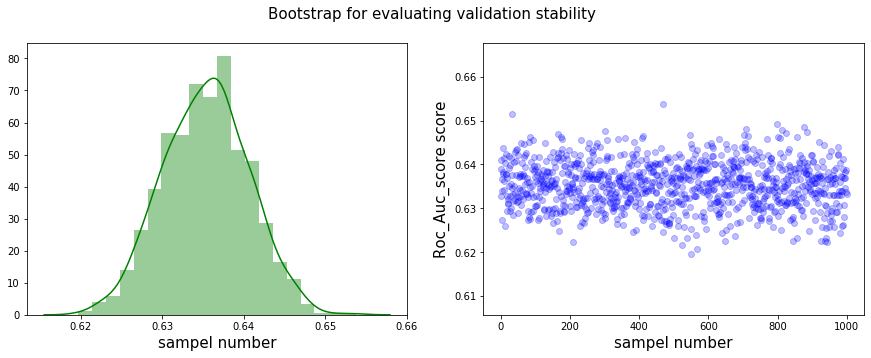

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("Roc_Auc_score score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

данные тестовой выборки лежат в пределах доверительного интервала. дальнейшее улучшение можно улучшить подбором гиперпараметров и созданием произаодных показателей.

#### 4. выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах

In [58]:
x_train=data_train.drop('isFraud',axis=1)
valid_test=test.drop('isFraud',axis=1)

In [59]:
x_adv = pd.concat([
    x_train, valid_test], axis=0)
y_adv = np.hstack((np.zeros(x_train.shape[0]), np.ones(valid_test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [60]:
model = catboost.CatBoostClassifier(random_state=21,cat_features=categorical_features,silent=True)
model.fit(x_adv, y_adv)

In [61]:
y_pred = model.predict_proba(x_train)

In [64]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    49825
(0.1, 0.2]        0
(0.2, 0.3]       46
(0.3, 0.4]        4
(0.4, 0.5]        6
(0.5, 0.6]       22
(0.6, 0.7]       98
(0.7, 0.8]        0
(0.8, 0.9]        0
(0.9, 1.0]        0
dtype: int64

In [73]:
y_pred = model.predict_proba(test.drop('isFraud',axis=1))

In [76]:
test_ROC_AUC = roc_auc_score(test['isFraud'], y_pred[:, 1])

print(f" Test-score: {round(test_ROC_AUC, 3)}")

 Test-score: 0.412


Итоговое качество ухудшилось.

#### 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных

In [19]:
x_train=data_train.drop('isFraud',axis=1)
y_train=data_train['isFraud']

In [23]:
scores_m1, scores_m2 = np.array([]), np.array([])

for i in range(4):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    cv_m1 = cross_val_score(
        estimator=catboost.CatBoostClassifier(cat_features=categorical_features,silent=True),
        X=x_train, y=y_train, cv=fold, scoring="roc_auc"
    )
    
    cv_m2 = cross_val_score(
        estimator=catboost.CatBoostClassifier(cat_features=categorical_features,silent=True),
        X=x_test, y=y_test, cv=fold, scoring="roc_auc"
    )
   
    scores_m2 = np.append(scores_m2, cv_m2)
    scores_m1 = np.append(scores_m1, cv_m1)
    

In [27]:
print(f"Train  model, CV-result: {round(np.mean(scores_m1[:5]), 4)} +/- {round(np.std(scores_m1[:5]), 4)}")
print(f"Test model, CV-result: {round(np.mean(scores_m2[:5]), 4)} +/- {round(np.std(scores_m2[:5]), 4)}")

Train  model, CV-result: 0.9104 +/- 0.0108
Test model, CV-result: 0.8928 +/- 0.0196


In [ ]:
Получен хороший результат кросвалидация стабильна. отклонения в пределах 0.01,0,02 что является хорошим показателем для модели